In [1]:
from collections import Counter
from typing import List 
import seaborn as sns

from LADCSBM import LADCSBM
from LADCSBM.utils import (
    generate_B,
    generate_X,
    generate_theta,
    generate_omega
    )
from LADCSBM.evals import *
from LADCSBM.plotting import *

## Generate a Labelled ADC-SBM Graph:

In [9]:
# 1) 3 equally sized communities.
community_sizes = [50, 50, 50]
cluster_sizes   = [65, 40, 45]
N = sum(community_sizes)

# 2) Generate Block-Matrix "B", where between-connection probabilities lie between 0.1 and 0.15 (randomly drawn)
# and within connection-probabilities lie between 0.6 and 0.7 => Community homophillic Grap. 

B = generate_B(
    m=3,
    b_range=(.1, .15),
    w_range=(.6, .7),
    rs=24
    )

# 3) Generate Feature-Matrix "X"
#  => 3 clusters in 2-dimensional space. 
X, cl = generate_X(
    n_observations=N,
    mu=[(-10,-10),(0,0),(10,10)], # 10 units apart from middle on average.
    sigma=[np.eye(2), np.eye(2), np.eye(2)], # round cluster-shapes. 
    w=cluster_sizes  # overlapping clusters and communities
    )

# 4) Generate Vector of Degree-Corrections "θ" from an exponential Distribution. 
theta = generate_theta(  # degree-corrections 
    community_sizes,
    distribution="exponential",
    seed=24,
    scale=1.0
    )

# 5) Generate an L-ADC-SBM Matrix from the previously generated parameters.

ladcsbm = LADCSBM(
    community_sizes=community_sizes,
    B=B,
    theta=theta,
    X=X,
    cluster_labels=cl
    )

# 6.1) generate a weight matrix for the features. 
omega = generate_omega(
        n_targets=3,
        n_communities=len(community_sizes), # specify the number of communities of the Graph
        k_clusters=3, # specify the number of clusters
        w_x=2.0, # boost for cluster weights
        w_com=3.0 # boost for community weights (more relevant predictor than cluster weights as 3.0 > 2.0)
    )

ladcsbm.set_y_from_X(omega=omega, eps=2.0) # generate labels vector with random noise (eps = 2.0).

G = ladcsbm

In [10]:
print(get_group_connectivity(G, group_by='targets'), "\n"*2)
print(get_group_connectivity(G, group_by='feature-cluster'), "\n"*2)
print(get_group_connectivity(G, group_by='communities'), "\n"*2)

     0    1    2
0  414  382  339
1  382  420  474
2  339  474  361 


     0    1    2
0  642  519  333
1  519  302  268
2  333  268  326 


     0    1    2
0  511  288  308
1  288  560  309
2  308  309  414 




## Evaluate the Generated Graph: 

In [ ]:
com:dict = nx.get_node_attributes(G, 'communities')
feat:dict = nx.get_node_attributes(G, 'features')
edges:list = G.edges(data=False)
targets:dict = nx.get_node_attributes(G, 'targets')

In [ ]:
n_t:int = len(set(targets.values()))  # Number of targets

counter = {i: {j: 0 for j in range(0, n_t)} for i in range(0, n_t)}
# {0: {0:_,1:_,2:_},1: {0:_,1:_,2:_}, 2: {0:_,1:_,2:_}} example for nt = 3
for e in edges:
    i, j = e 
    target_i = targets[i]
    target_j = targets[j] 
    if target_i == target_j:
        counter[target_i][target_j] += 1
    else:
        counter[target_i][target_j] += 1
        counter[target_j][target_i] += 1

df = pd.DataFrame(counter)
df

,0,1,2
0,73,58,42
1,58,185,66
2,42,66,77


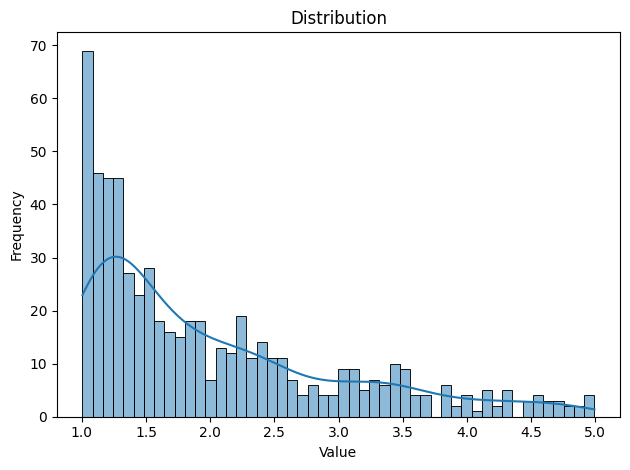

In [ ]:
def plot_distribution(
        data: np.array,
        bins: int = 50,
        title: str = "Distribution"
        ):
    """
    Plot the distribution of a NumPy array.

    :param data: NumPy array (can be 1D or 2D)
    :param bins: Number of histogram bins
    :param title: Plot title
    """
    flat_data = data.flatten()  # flatten in case it's 2D
    sns.histplot(flat_data, bins=bins, kde=True)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_distribution(theta)

In [6]:
def get_empirical_B(G:nx.Graph):
    """
    :param G: a NetworkX graph. 
    """

    edges:list = G.edges(data=False) # [(0, 3), (0, 4), ...
    k:int = len(community_sizes) # community_sizes e.g.: [10, 20, 30]
    B_emp = np.zeros((k, k))

    for (node_i, node_j) in edges:
        com_of_node_i, com_of_node_j = com[node_i], com[node_j]
        B_emp[com_of_node_i, com_of_node_j] += 1

    upper_triangular = np.triu(B_emp)

    diagonal = np.diag(np.diag(upper_triangular))
    B_emp = upper_triangular + upper_triangular.T - diagonal

    return B_emp

get_empirical_B(G)

array([[ 4879.,   814.,  1249.],
       [  814., 19417.,  2366.],
       [ 1249.,  2366., 43986.]])

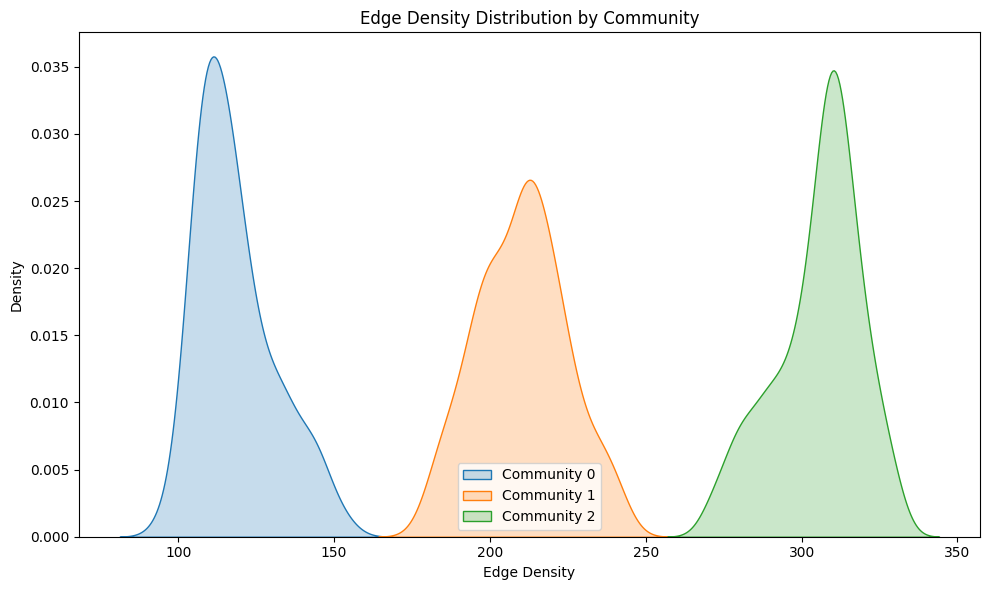

In [8]:

def plot_edge_densities(G:nx.Graph, by_community:bool=True) -> None:
    """
    :param G: a NetworkX graph. 
    :param by_community: specifying, whether the plot should be grouped by community. 
    """
    # Extract node degrees
    node_degrees = [G.degree[node] for node in G.nodes]

    if by_community:
        # Extract community assignments
        community_dict = nx.get_node_attributes(G, 'communities')
        if not community_dict:
            raise ValueError("Graph does not have 'community' node attributes")

        community_labels = sorted(set(community_dict.values()))

        # Group edge densities by community
        densities_by_community = {
            l: [G.degree[node] for node in G.nodes if community_dict[node] == l]
            for l in community_labels
        }

        # Plot densities per community
        plt.figure(figsize=(10, 6))
        for label, densities in densities_by_community.items():
            sns.kdeplot(densities, label=f"Community {label}", fill=True)
        plt.title("Edge Density Distribution by Community")
    else:
        # Plot overall density
        plt.figure(figsize=(10, 6))
        sns.kdeplot(node_degrees, label="All Nodes", fill=True)
        plt.title("Overall Edge Density Distribution")

    plt.xlabel("Edge Density")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_edge_densities(G, by_community=True)